In [246]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import re

import nltk
from wordcloud import WordCloud

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer


In [2]:
import kagglehub

path = kagglehub.dataset_download("aditya1220/hate-speech-detection-dataset")
print("Path to dataset files:", path)


Path to dataset files: /home/carlos/.cache/kagglehub/datasets/aditya1220/hate-speech-detection-dataset/versions/1


In [3]:
# Verificar quais arquivos existem dentro da pasta baixada
print(os.listdir(path))

# Montar o caminho para o arquivo de treino
csv_path = os.path.join(path, "Dataset/Split Dataset/Training_meme_dataset.csv")

# Carregar com pandas
df = pd.read_csv(csv_path)

df


['Dataset']


,image_name,sentence,label
0,LJ3r8Gy.jpg.png,OFFICIAL BERNIE SANDERS DRINKING GAME ! Every ...,Non-offensiv
1,qDnIIHA.png,2:28 PM THIS IS A WALL INSIDE A NAZI GAS CHAMB...,offensive
2,1JQk5NF.png,o shit waddup ! BERNIE SANDERS COM,offensive
3,iMMNq.png,`` MITT ROMNEY IS THE WORST REPUBLICAN IN THE ...,Non-offensiv
4,jAi3iI1.png,Anonymous ( ID : duqdA1io a 08/05/16 ( Fri ) 1...,Non-offensiv
...,...,...,...
440,a1F6RKt.png,`` I HOPE '' THE TRUMP FOUNDATION HAS N'T BROK...,Non-offensiv
441,ZEjNdo0.png,31 6:26 PM geez . 5 minutes ago I know Bernie ...,Non-offensiv
442,34nLFqO.png,"*me , voting for Bernie Sanders Feel the Bern !",Non-offensiv
443,gzWfYg3.png,YOU SAIOTHATAVOTEFORGARY JOHNSONWASAVOTEFOR HI...,offensive


In [4]:
df.shape

(445, 3)

In [5]:
df.columns

Index(['image_name', 'sentence', 'label'], dtype='object')

In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

image_name    0
sentence      0
label         0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  445 non-null    object
 1   sentence    445 non-null    object
 2   label       445 non-null    object
dtypes: object(3)
memory usage: 10.6+ KB


In [9]:
df.nunique()

image_name    445
sentence      445
label           2
dtype: int64

In [10]:
df['label'].unique()

array(['Non-offensiv', 'offensive'], dtype=object)

In [11]:
df['label'].value_counts()

label
Non-offensiv    258
offensive       187
Name: count, dtype: int64

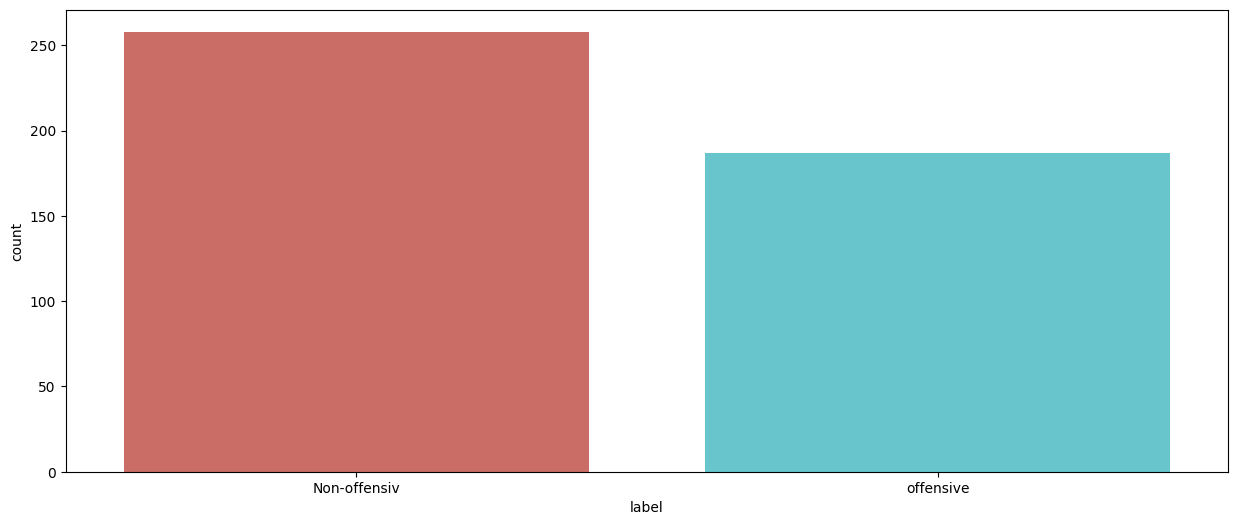

In [12]:
plt.figure(figsize=(15,6))
sns.countplot(x = 'label', data = df, palette = 'hls')
plt.show()

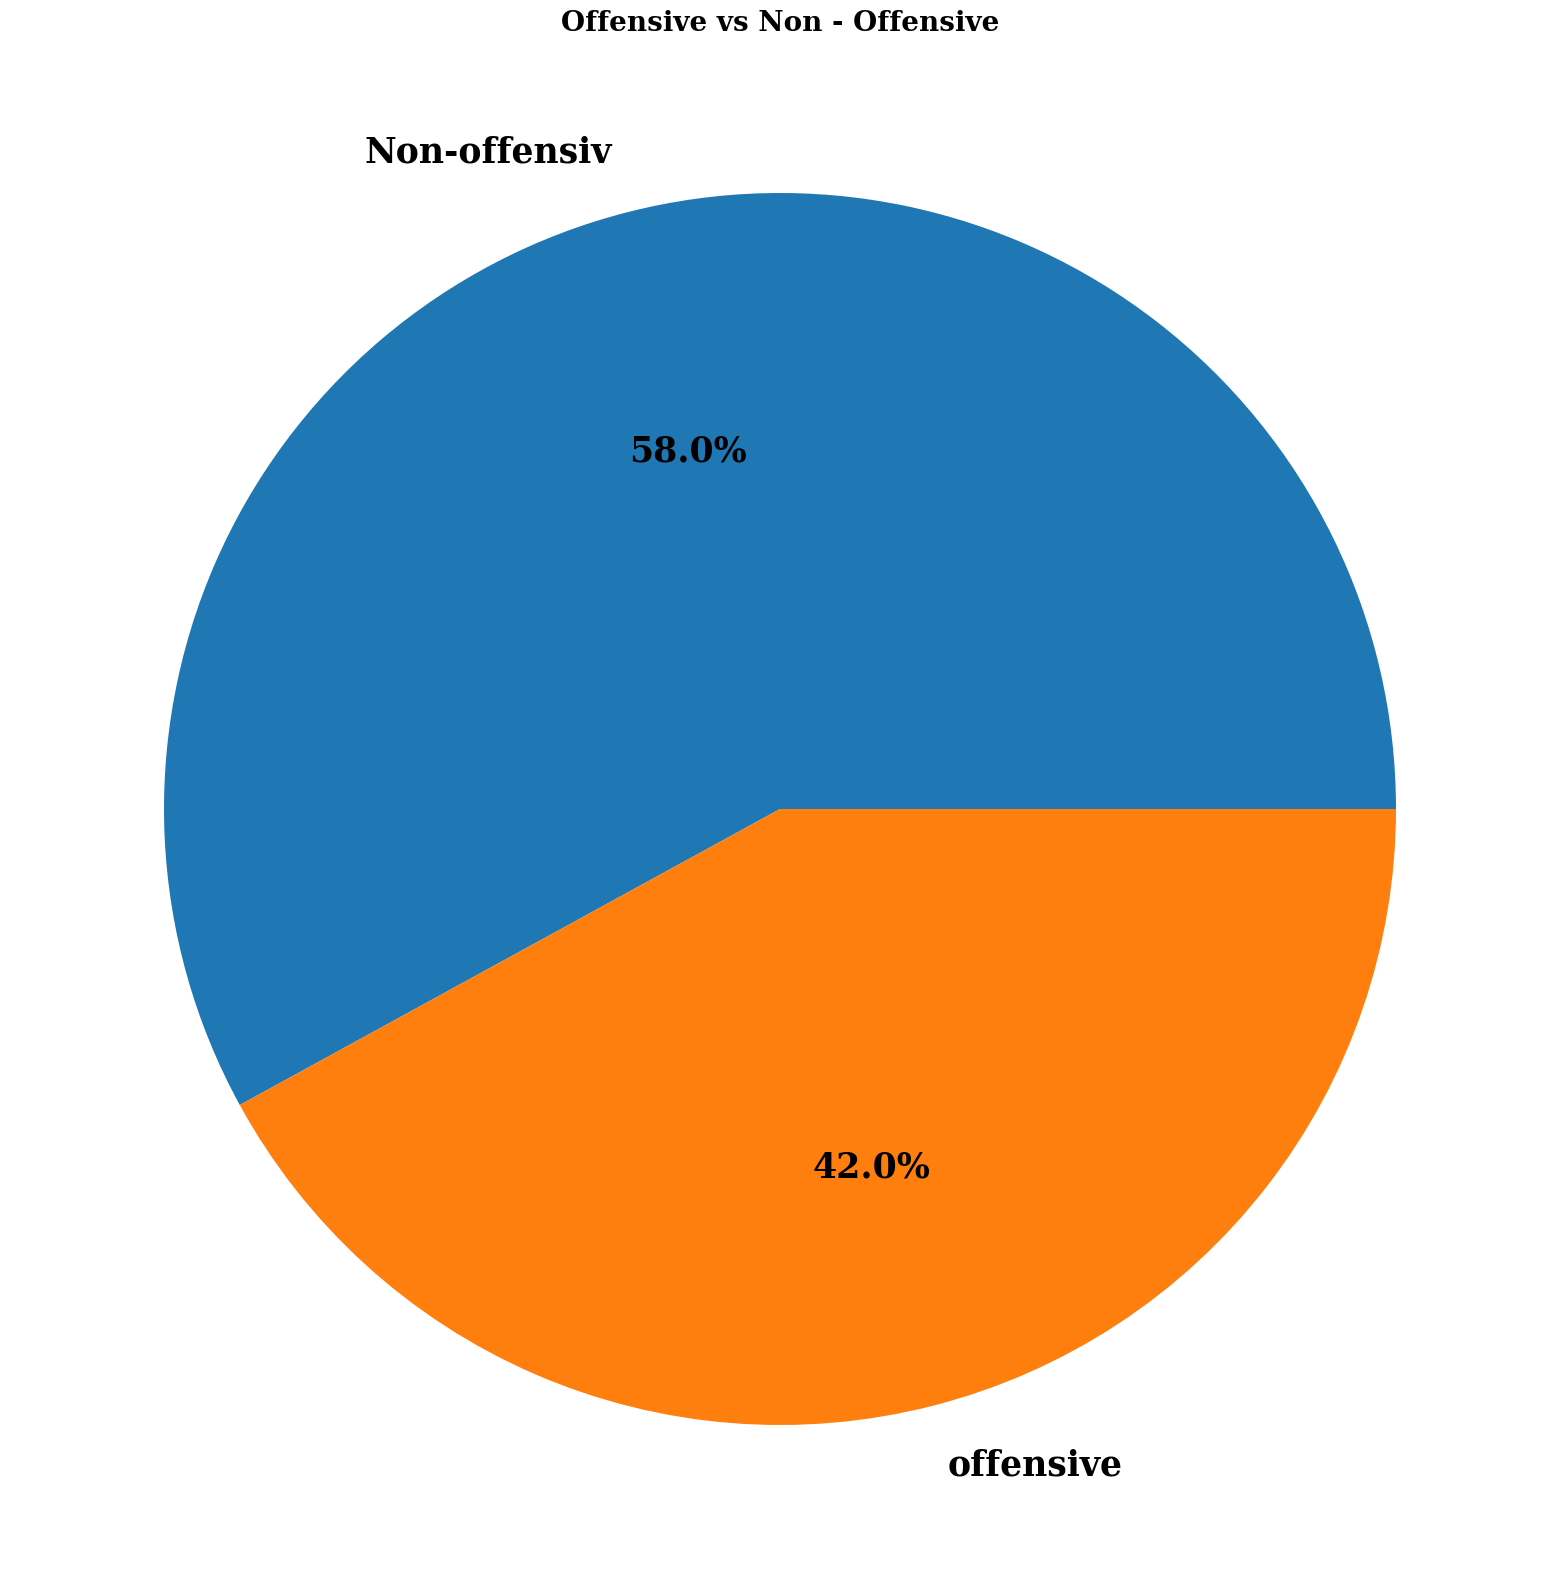

In [13]:
plt.figure(figsize=(30,20)) 
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index, 
        autopct='%1.1f%%', textprops={ 'fontsize': 25,
                                       'color': 'black',
                                        'weight': 'bold',
                                        'family': 'serif' }) 
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Offensive vs Non - Offensive', size=20, **hfont) 
plt.show()

In [188]:
df_new = df.copy()

In [189]:
def clean_text(text):
    text = text.lower()
    text = text.strip()
    return text


In [190]:
df_new['sentence'] = df_new['sentence'].astype(str).apply(clean_text)


In [191]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [192]:
def remove_punctuation(text):
    return "".join(i for i in text if i not in string.punctuation)


In [193]:
df_new['sentence'] = df_new['sentence'].apply(remove_punctuation)


In [194]:
def tokenization(text):
    # Use a regular expression to split the text into tokens
    tokens = re.split(r'\W+', text)
    return tokens

In [195]:
df_new['sentence']= df_new['sentence'].apply(lambda x: tokenization(x))

In [196]:
df_new['sentence']

0      [official, bernie, sanders, drinking, game, ev...
1      [228, pm, this, is, a, wall, inside, a, nazi, ...
2                [o, shit, waddup, bernie, sanders, com]
3      [, mitt, romney, is, the, worst, republican, i...
4      [anonymous, id, duqda1io, a, 080516, fri, 1632...
                             ...                        
440    [, i, hope, the, trump, foundation, has, nt, b...
441    [31, 626, pm, geez, 5, minutes, ago, i, know, ...
442    [me, voting, for, bernie, sanders, feel, the, ...
443    [you, saiothatavoteforgary, johnsonwasavotefor...
444    [weratedogs, follow, dog, rates, this, is, ber...
Name: sentence, Length: 445, dtype: object

In [198]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/carlos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/carlos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## VADER (Valence Aware Dictionary and sEntiment Reasoner)

O **VADER** é uma ferramenta de análise de sentimentos baseada em regras, projetada especificamente para analisar o sentimento em textos, especialmente em conteúdos de redes sociais como tweets.  
Ele é pré-treinado com um léxico de sentimentos que contém palavras anotadas com sua polaridade (positiva, negativa ou neutra) e com pontuações de intensidade.

O VADER consegue lidar tanto com a **polaridade do sentimento** quanto com a **intensidade**, fornecendo não apenas se um texto é positivo, negativo ou neutro, mas também o quão intenso é esse sentimento.  
É muito útil para analisar rapidamente textos curtos e informais, sem a necessidade de dados de treinamento ou modelos complexos.

---

## Corpus de Stopwords

**Stopwords** são palavras comuns que geralmente são removidas do texto durante tarefas de processamento de linguagem natural (PLN), pois normalmente não carregam um significado relevante para a tarefa em questão.

O **NLTK** fornece um corpus de stopwords que contém listas dessas palavras em vários idiomas, como inglês, francês, alemão, entre outros.  
Essas stopwords incluem palavras frequentes como *"the"*, *"and"*, *"is"*, *"in"*, etc., que aparecem com muita frequência nos textos, mas não contribuem significativamente para sua compreensão ou análise.

A remoção de stopwords pode ajudar a melhorar o desempenho e a eficiência de tarefas de PLN, como **classificação de texto**, **modelagem de tópicos** e **recuperação de informação**, ao reduzir ruídos e focar em palavras mais relevantes.

---

O **VADER** é uma ferramenta voltada para **análise de sentimentos**, enquanto o **Corpus de Stopwords** fornece listas de palavras comuns que geralmente são removidas durante o pré-processamento de texto. Ambos são recursos úteis para tarefas de processamento de linguagem natural em Python.


In [201]:
stopwords = nltk.corpus.stopwords.words('english')


In [202]:
def remove_stopwords(text):
    output= " ".join(i for i in text if i not in stopwords)
    return output

In [204]:
df_new['sentence']= df_new['sentence'].apply(lambda x:remove_stopwords(x))

In [205]:
df_new['sentence']

0      official bernie sanders drinking game every ti...
1      228 pm wall inside nazi gas chamber dwebs demo...
2                         shit waddup bernie sanders com
3       mitt romney worst republican country putup ba...
4      anonymous id duqda1io 080516 fri 163248 842315...
                             ...                        
440     hope trump foundation nt broken laws personal...
441    31 626 pm geez 5 minutes ago know bernie fathe...
442                     voting bernie sanders feel bern 
443    saiothatavoteforgary johnsonwasavotefor hillar...
444    weratedogs follow dog rates bernie touched boo...
Name: sentence, Length: 445, dtype: object

## WordNet

O **WordNet** é um banco de dados lexical da língua inglesa que fornece relações semânticas entre palavras, como **sinônimos**, **antônimos**, **hiperônimos**, **hipônimos**, entre outras.  
Ele é um recurso valioso para diversas tarefas de **processamento de linguagem natural (PLN)**, incluindo **desambiguação de sentido de palavras**, **medição de similaridade semântica** e **recuperação de informação**.

---

## Casos de Uso Comuns do WordNet

### 🔹 Encontrar Sinônimos e Antônimos
O WordNet fornece conjuntos de sinônimos (*synsets*) para palavras, permitindo encontrar palavras alternativas com significados semelhantes ou opostos.

### 🔹 Explorar Hierarquias de Palavras
O WordNet organiza palavras em hierarquias com base em suas relações semânticas, como:
- **Hiperônimos**: termos mais gerais  
- **Hipônimos**: termos mais específicos

### 🔹 Desambiguação de Sentido de Palavras
O WordNet ajuda a identificar o significado correto de palavras que possuem múltiplos sentidos, fornecendo definições e relações semânticas.

### 🔹 Análise de Texto e Recuperação de Informação
O WordNet pode ser utilizado para aprimorar tarefas de análise de texto, como **classificação de documentos**, **agrupamento (clustering)** e **recuperação de informação**, incorporando conhecimento semântico.

---

Para explorar melhor o WordNet, você pode utilizar as funções fornecidas pelo **NLTK**, que permitem acessar recursos como sinônimos, antônimos, hiperônimos, hipônimos e muito mais.  
Se quiser, posso fornecer exemplos de como usar funções específicas do WordNet no NLTK — é só avisar!


In [206]:
porter_stemmer = PorterStemmer()

def stemmer(sentence):
    words = word_tokenize(sentence)
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    stemmed_sentence = ' '.join(stemmed_words)
    return stemmed_sentence

df_new['sentence'] = df_new['sentence'].apply(lambda x: stemmer(x))

In [219]:
def clean_text(text):
    text = re.sub('\[.*\]','', text).strip() 
    text = re.sub('\S*\d\S*\s*','', text).strip()  
    return text.strip()

In [220]:
df_new['sentence']

0      offici berni sander drink game everi time bern...
1      pm wall insid nazi ga chamber dweb democrat me...
2                           shit waddup berni sander com
3      mitt romney worst republican countri putup bar...
4      anonym id fri file imag jpg kb repeat digit pa...
                             ...                        
440    hope trump foundat nt broken law person sign c...
441    pm geez minut ago know berni father famili kil...
442                          vote berni sander feel bern
443    saiothatavoteforgari johnsonwasavotefor hillar...
444    weratedog follow dog rate berni touch boob fir...
Name: sentence, Length: 445, dtype: object

Essa função `clean_text` parece ter sido projetada para realizar algumas operações básicas de limpeza de texto utilizando **expressões regulares**. Vamos analisar o que cada linha faz:

- **`text = re.sub('\[.*\]','', text).strip()`**  
  Esta linha utiliza uma expressão regular para remover qualquer texto que esteja entre colchetes `[...]`.

  - `\[.*\]` corresponde a qualquer sequência de caracteres entre colchetes.
  - `re.sub()` é usado para substituir o padrão encontrado por uma string vazia, removendo esse trecho do texto.
  - `.strip()` remove espaços em branco no início e no final da string.

- **`text = re.sub('\S*\d\S*\s*','', text).strip()`**  
  Esta linha utiliza uma expressão regular para remover sequências de caracteres que contenham **dígitos**.

  - `\S*\d\S*` corresponde a qualquer sequência de caracteres não brancos que contenha pelo menos um dígito (`\d`).
  - `\S*` captura caracteres não brancos antes e depois do dígito.
  - `\s*` captura possíveis espaços em branco após a sequência.
  - `re.sub()` substitui essas sequências por uma string vazia.
  - `.strip()` é aplicado novamente para remover espaços residuais no início e no final do texto.

- **`return text.strip()`**  
  Garante que qualquer espaço em branco restante nas extremidades do texto seja removido antes de retornar o resultado final.

**Em resumo**, essa função tem como objetivo remover padrões específicos do texto de entrada, como conteúdos entre colchetes e sequências que contenham números, retornando um texto limpo e sem espaços desnecessários nas extremidades.


In [221]:
df_new['sentence'] = df_new['sentence'].apply(lambda x: clean_text(x))

In [222]:
def remove_urls(vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

In [224]:
df_new['sentence'] = df_new['sentence'].apply(lambda x: remove_urls(x))

In [233]:
def remove_digits(text):
    clean_text = re.sub(r"\b[0-9]+\b\s*", "", text)
    return(text)

In [234]:
df_new['sentence'] = df_new['sentence'].apply(lambda x: remove_digits(x))

In [235]:
def remove_emojis(data):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               "]+", flags=re.UNICODE)
    return re.sub(emoji_pattern, '', data)

In [236]:
df_new['sentence'] = df_new['sentence'].apply(lambda x: remove_emojis(x))

In [237]:
df_new['sentence'] = df_new['sentence'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

In [238]:
df_new['sentence'] = df_new['sentence'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [240]:
df_new


,image_name,sentence,label
0,LJ3r8Gy.jpg.png,offici berni sander drink game everi time bern...,Non-offensiv
1,qDnIIHA.png,pm wall insid nazi ga chamber dweb democrat me...,offensive
2,1JQk5NF.png,shit waddup berni sander com,offensive
3,iMMNq.png,mitt romney worst republican countri putup bar...,Non-offensiv
4,jAi3iI1.png,anonym id fri file imag jpg kb repeat digit pa...,Non-offensiv
...,...,...,...
440,a1F6RKt.png,hope trump foundat nt broken law person sign c...,Non-offensiv
441,ZEjNdo0.png,pm geez minut ago know berni father famili kil...,Non-offensiv
442,34nLFqO.png,vote berni sander feel bern,Non-offensiv
443,gzWfYg3.png,saiothatavoteforgari johnsonwasavotefor hillar...,offensive


In [241]:
def remove_punctuation(text):
    punctuation_pattern = r'[^\w\s]'
    return re.sub(punctuation_pattern, '', text)

df_new['sentence'] = df_new['sentence'].apply(remove_punctuation)

In [242]:
df_new

,image_name,sentence,label
0,LJ3r8Gy.jpg.png,offici berni sander drink game everi time bern...,Non-offensiv
1,qDnIIHA.png,pm wall insid nazi ga chamber dweb democrat me...,offensive
2,1JQk5NF.png,shit waddup berni sander com,offensive
3,iMMNq.png,mitt romney worst republican countri putup bar...,Non-offensiv
4,jAi3iI1.png,anonym id fri file imag jpg kb repeat digit pa...,Non-offensiv
...,...,...,...
440,a1F6RKt.png,hope trump foundat nt broken law person sign c...,Non-offensiv
441,ZEjNdo0.png,pm geez minut ago know berni father famili kil...,Non-offensiv
442,34nLFqO.png,vote berni sander feel bern,Non-offensiv
443,gzWfYg3.png,saiothatavoteforgari johnsonwasavotefor hillar...,offensive


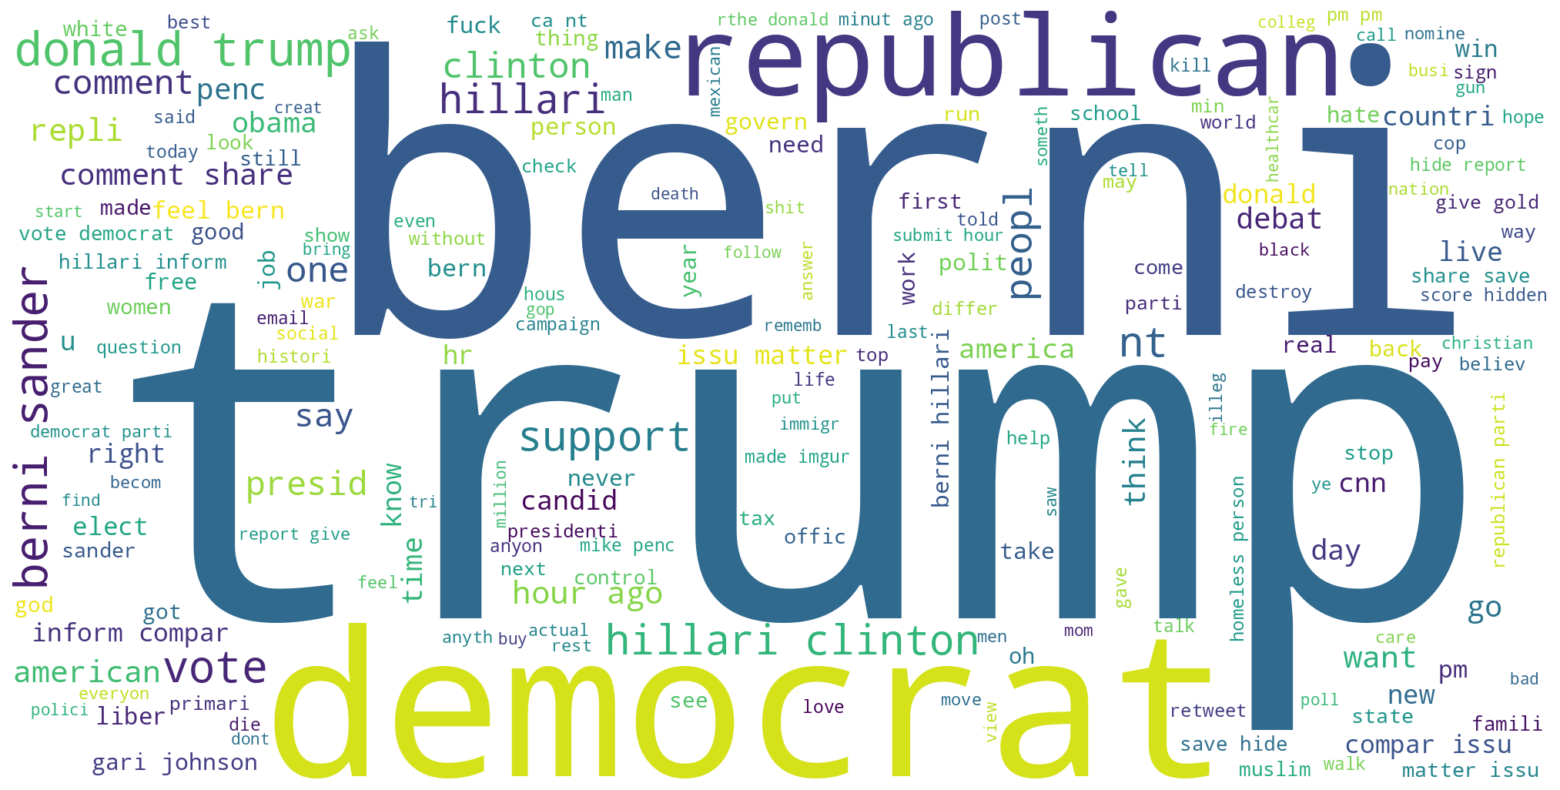

In [248]:


text_data = ' '.join(df_new['sentence'])

wordcloud = WordCloud(
    background_color='white',
    width=2000,
    height=1000
).generate(text_data)

# Converte via PIL (sem usar to_array)
wc_image = np.array(wordcloud.to_image())

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(wc_image, interpolation='bilinear')
ax.axis('off')
plt.show()


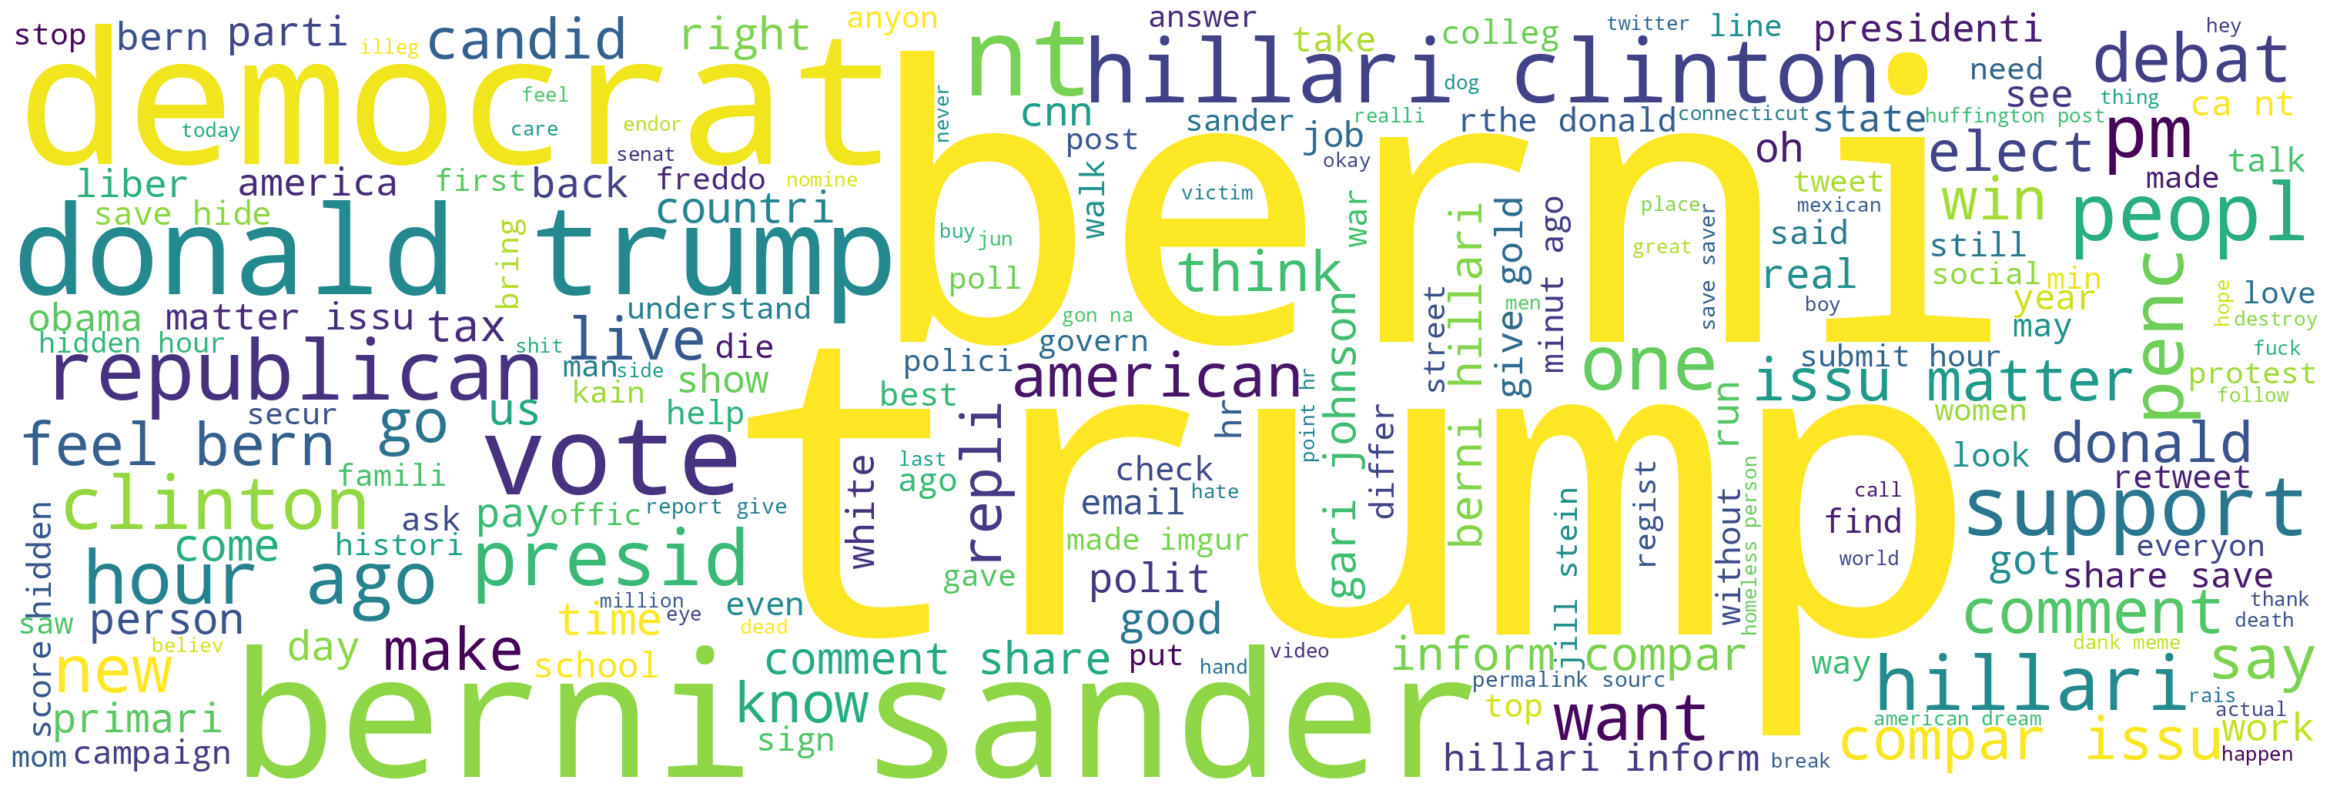

In [257]:
nonoffensive_text_data = ' '.join(
    df_new[df_new['label'] == 'Non-offensiv']['sentence']
)

if nonoffensive_text_data:
    wordcloud = WordCloud(
        background_color='white',
        width=3000,
        height=1000
    ).generate(nonoffensive_text_data)

    fig, ax = plt.subplots(figsize=(30, 10))
    
    # 🔥 CONVERSÃO CORRETA (PIL → NumPy)
    ax.imshow(np.array(wordcloud.to_image()), interpolation='bilinear')
    
    ax.axis('off')
    plt.savefig(
        'nonoffensive_text_data_wordcloud1.png',
        bbox_inches='tight',
        pad_inches=0
    )
    plt.show()
else:
    print('No nonoffensive text data to generate a word cloud.')


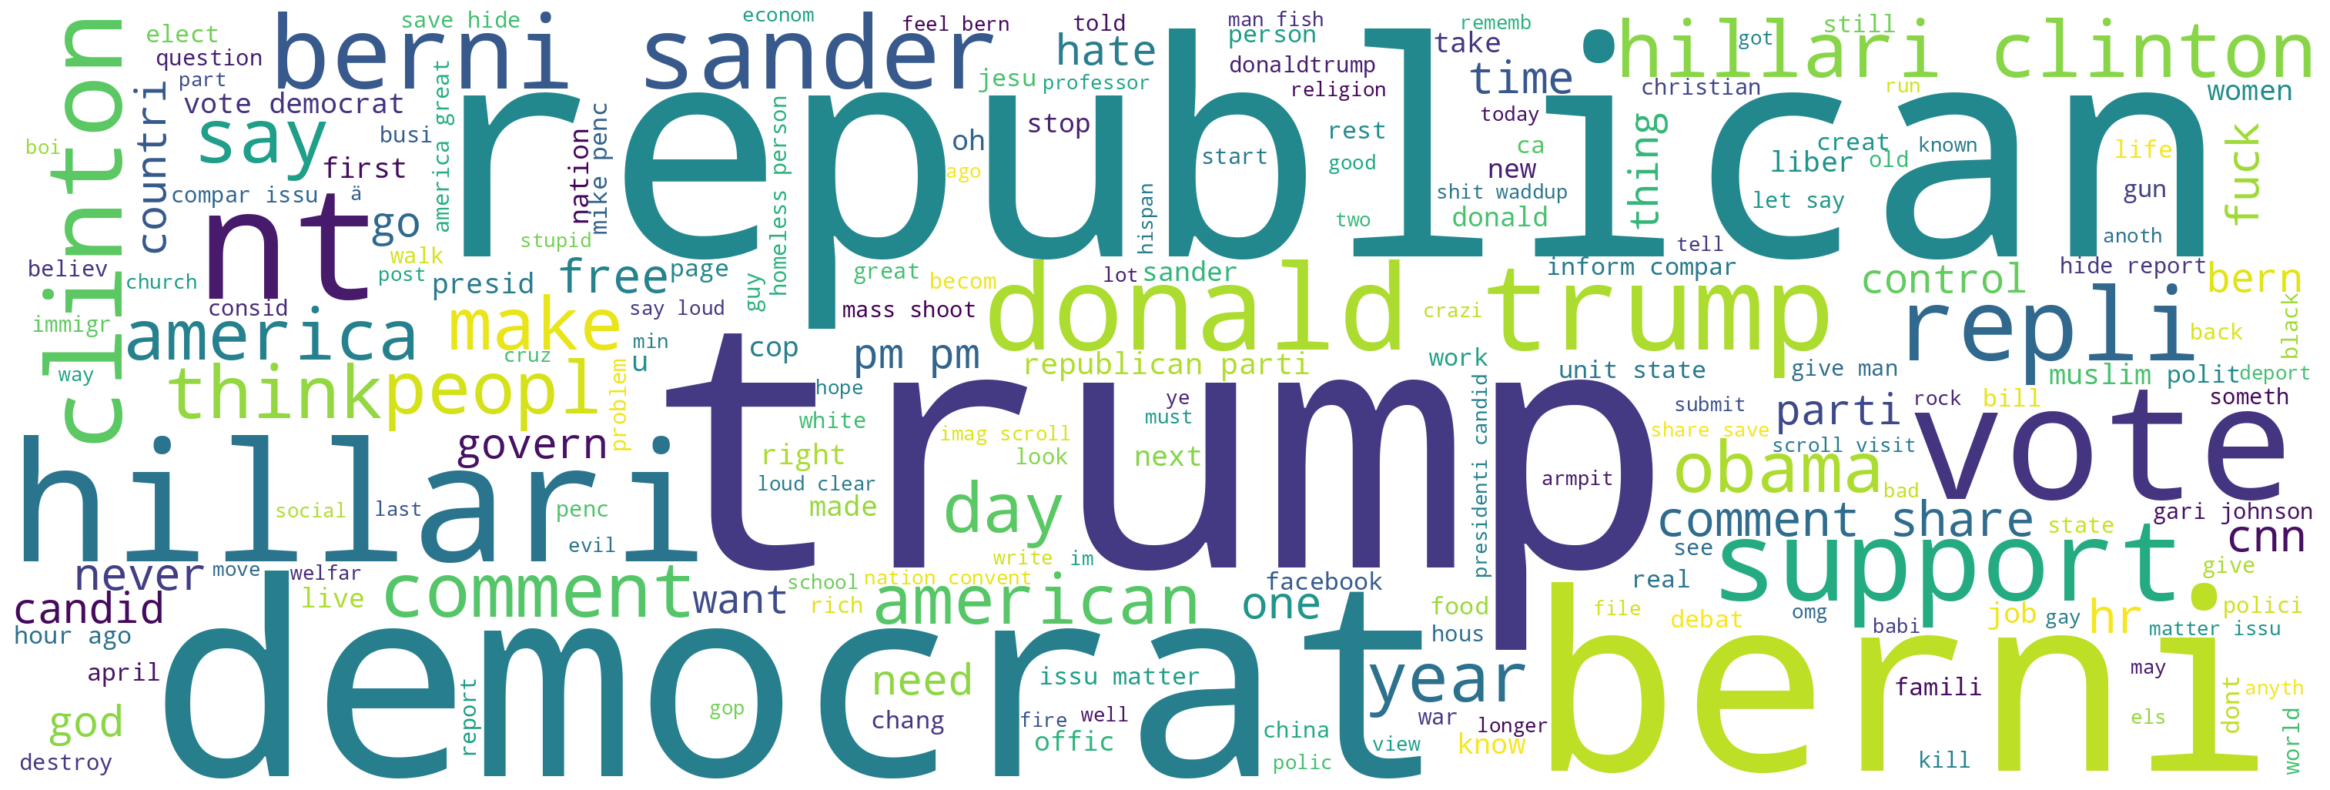

In [259]:
offensive_text_data = ' '.join(
    df_new[df_new['label'] == 'offensive']['sentence']
)

if offensive_text_data:
    wordcloud = WordCloud(
        background_color='white',
        width=3000,
        height=1000
    ).generate(offensive_text_data)

    fig, ax = plt.subplots(figsize=(30, 10))

    # 🔥 Conversão correta (PIL → NumPy)
    ax.imshow(np.array(wordcloud.to_image()), interpolation='bilinear')

    ax.axis('off')
    plt.savefig(
        'offensive_text_data_wordcloud1.png',
        bbox_inches='tight',
        pad_inches=0
    )
    plt.show()
else:
    print('No offensive text data to generate a word cloud.')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([Dense(1, input_shape=(10,))])
model.summary()
